# Importation des librairies

In [1]:
#import os
#cwd = os.getcwd()
#cwd

In [2]:
#!pip install openpyxl

In [3]:
#!pip install geopandas

In [4]:
# Pandas est une bibliothèque logicielle écrite pour le langage de programmation Python pour la manipulation et l'analyse de données.
import pandas as pd
# NumPy est une bibliothèque pour le langage de programmation Python, ajoutant la prise en charge de grands tableaux et matrices multidimensionnels, ainsi qu'une large collection de fonctions mathématiques de haut niveau pour opérer sur ces tableaux.
import numpy as np
# Matplotlib est une bibliothèque de traçage pour Python et pyplot nous offre un cadre de traçage de type MatLab. Nous l'utiliserons dans notre fonction de traceur pour tracer des données.
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
# Seaborn est une bibliothèque de visualisation de données Python basée sur matplotlib. Il fournit une interface de haut niveau pour dessiner des graphiques statistiques attrayants et informatifs
import seaborn as sns

# Importation des librairies pour la représentation cartographique
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from folium.plugins import MarkerCluster

# Importation de la table et analyse exploratoire

In [5]:
data_hydo = pd.read_excel('consommation-historique-region-administrative-11mars2024.xlsx')
df0 = pd.DataFrame(data_hydo)
df_conso = df0.copy()
df_conso['ANNEE_MOIS'] = pd.to_datetime(df_conso['ANNEE_MOIS'])
df_conso['ANNEE'], df_conso['MOIS'] = df_conso['ANNEE_MOIS'].dt.year, df_conso['ANNEE_MOIS'].dt.month
df_conso['ANNEE_MOIS'] = df_conso['ANNEE_MOIS'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
df_conso.head()

REGION_ADM_QC_TXT ANNEE_MOIS         SECTEUR   Total (kWh)  ANNEE  MOIS
0  Abitibi-Témiscamingue    2016-01        AGRICOLE  3.704146e+06   2016     1
1  Abitibi-Témiscamingue    2016-01      COMMERCIAL  5.455593e+07   2016     1
2  Abitibi-Témiscamingue    2016-01      INDUSTRIEL  3.153137e+08   2016     1
3  Abitibi-Témiscamingue    2016-01  INSTITUTIONNEL  3.128970e+07   2016     1
4  Abitibi-Témiscamingue    2016-01     RÉSIDENTIEL  1.756439e+08   2016     1

In [6]:
df_conso.shape

(8160, 6)

In [7]:
df_conso.isnull().sum()

REGION_ADM_QC_TXT       0
ANNEE_MOIS              0
SECTEUR                 0
Total (kWh)          1640
ANNEE                   0
MOIS                    0
dtype: int64

In [8]:
#Remplacement des valeurs na de la colonne Total (kWh) par 0
df_conso = df_conso.fillna(0)

In [9]:
df_conso.isnull().sum()

REGION_ADM_QC_TXT    0
ANNEE_MOIS           0
SECTEUR              0
Total (kWh)          0
ANNEE                0
MOIS                 0
dtype: int64

In [10]:
# Conversion de la colonne Total (kWh) en variable numérique
df_conso['Total (kWh)'] = df_conso['Total (kWh)'].astype(int)

In [11]:
df_conso.dtypes

REGION_ADM_QC_TXT    object
ANNEE_MOIS           object
SECTEUR              object
Total (kWh)           int32
ANNEE                 int32
MOIS                  int32
dtype: object

In [12]:
df_conso['REGION_ADM_QC_TXT'].unique()

array(['Abitibi-Témiscamingue', 'Bas-Saint-Laurent', 'Capitale-Nationale',
       'Centre-du-Québec', 'Chaudière-Appalaches', 'Côte-Nord', 'Estrie',
       'Gaspésie--Îles-de-la-Madeleine', 'Lanaudière', 'Laurentides',
       'Laval', 'Mauricie', 'Montréal', 'Montérégie', 'Nord-du-Québec',
       'Outaouais', 'Saguenay--Lac-Saint-Jean'], dtype=object)

In [13]:
df_conso['SECTEUR'].unique()

array(['AGRICOLE', 'COMMERCIAL', 'INDUSTRIEL', 'INSTITUTIONNEL',
       'RÉSIDENTIEL'], dtype=object)

# Analyse Descriptive

### A- Secteurs VS Consommation

#### Diagramme Circulaire

In [14]:
df_secteur= df_conso.groupby(['SECTEUR'])['Total (kWh)'].sum().reset_index().set_index('SECTEUR')
df_secteur.head()

Total (kWh)
SECTEUR                     
AGRICOLE         14079528140
COMMERCIAL      217960735425
INDUSTRIEL      432982965800
INSTITUTIONNEL   73716058162
RÉSIDENTIEL     459574931636

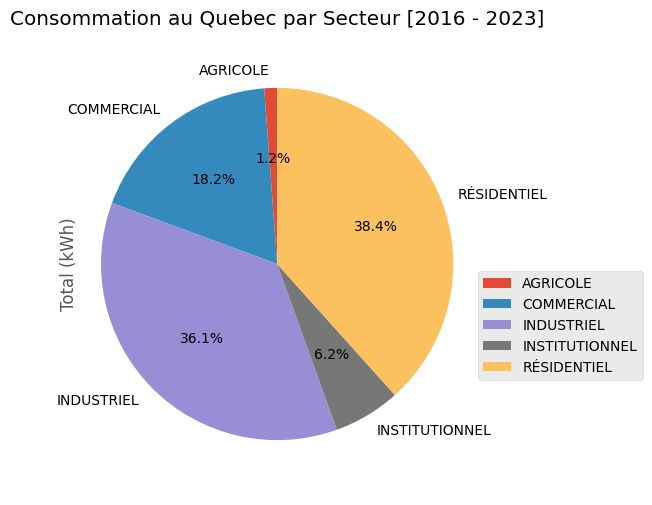

In [15]:
# Diagramme circulaire
df_secteur['Total (kWh)'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # ajouter des pourcentages
                            startangle=90,     # angle de départ 90°
                            )

plt.title('Consommation au Quebec par Secteur [2016 - 2023]')
plt.axis('equal') # Définit le diagramme circulaire pour qu'il ressemble à un cercle.
plt.legend(labels=df_secteur.index,loc='upper left', bbox_to_anchor=(1, 0.5))

plt.show()

__INTERPRETATION__ : Le secteur ayant la plus forte consommation est le secteur Résidentiel, suivi du secteur Industriel, Commercial, Institutionnel et enfin agricole.

#### Boites à moustache

In [16]:
df_secteur2_0 = df_conso.groupby(['SECTEUR', 'ANNEE'])['Total (kWh)'].sum().reset_index()
df_secteur2_1 = pd.crosstab(df_secteur2_0['ANNEE'], df_secteur2_0['SECTEUR'],values=df_secteur2_0['Total (kWh)'], aggfunc='sum')

In [17]:
df_secteur2_1.describe()

SECTEUR      AGRICOLE    COMMERCIAL    INDUSTRIEL  INSTITUTIONNEL  \
count    8.000000e+00  8.000000e+00  8.000000e+00    8.000000e+00   
mean     1.759941e+09  2.724509e+10  5.412287e+10    9.214507e+09   
std      1.211716e+08  8.986697e+08  2.350727e+09    1.674841e+08   
min      1.520304e+09  2.604075e+10  5.042930e+10    8.943404e+09   
25%      1.719130e+09  2.650335e+10  5.287518e+10    9.138605e+09   
50%      1.776117e+09  2.737310e+10  5.441055e+10    9.197065e+09   
75%      1.827564e+09  2.808370e+10  5.580876e+10    9.297625e+09   
max      1.903447e+09  2.817810e+10  5.731319e+10    9.493653e+09   

SECTEUR   RÉSIDENTIEL  
count    8.000000e+00  
mean     5.744687e+10  
std      1.383633e+09  
min      5.563772e+10  
25%      5.639202e+10  
50%      5.729990e+10  
75%      5.867232e+10  
max      5.923686e+10

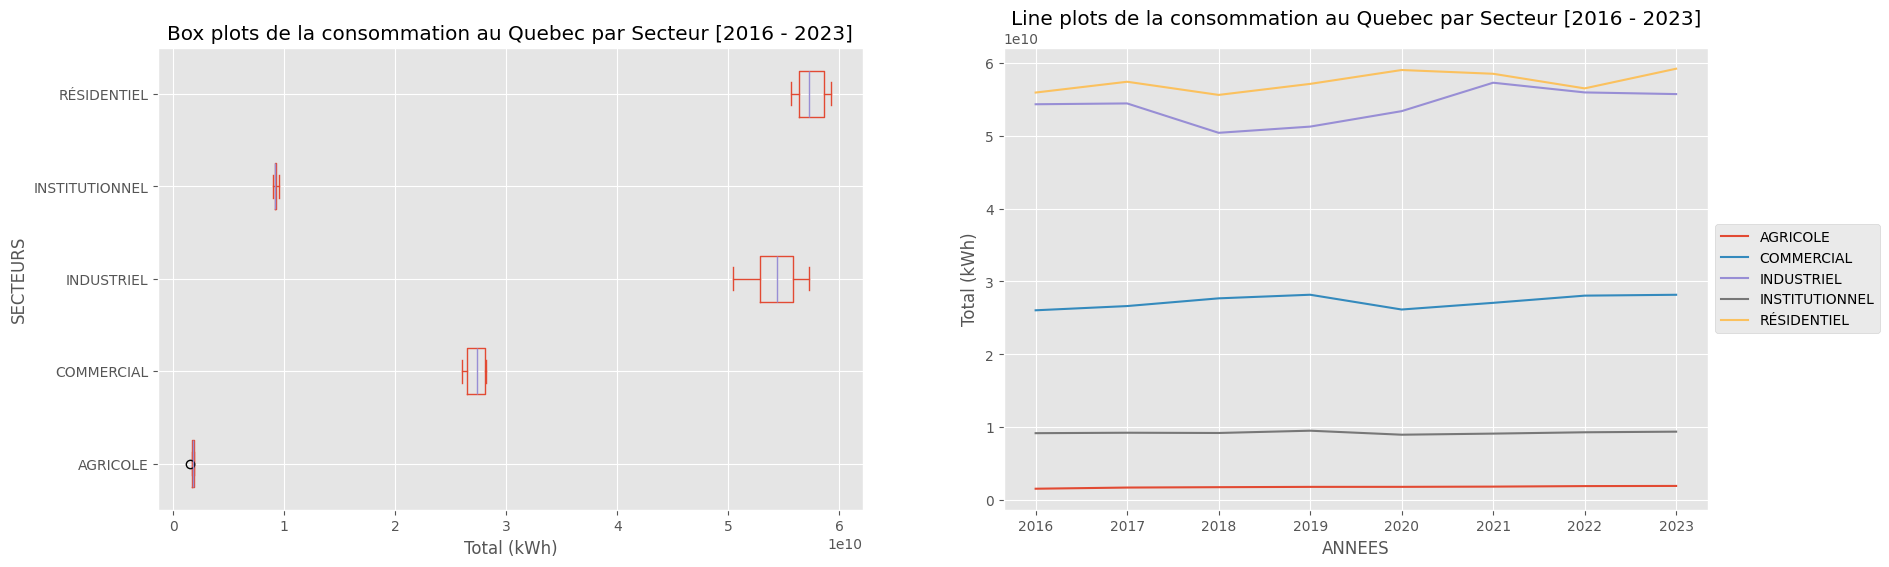

In [18]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
df_secteur2_1.plot(kind='box', vert=False, figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Box plots de la consommation au Quebec par Secteur [2016 - 2023]')
ax0.set_xlabel('Total (kWh)')
ax0.set_ylabel('SECTEURS')

# Subplot 2: Line plot
df_secteur2_1.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Line plots de la consommation au Quebec par Secteur [2016 - 2023]')
ax1.set_ylabel('Total (kWh)')
ax1.set_xlabel('ANNEES')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

__INTERPRETATION__ : 
> 1- Le secteur ayant la plus forte consommation est le secteur Résidentiel, suivi du secteur Industriel, Commercial, Institutionnel et enfin agricole.   
> 2- La consommation induite par le secteur résidentiel est telle que, de janvier 2016 à décembre 2023, la consommation moyenne de ce secteur (soit 5.910387e+10 kWh) a été supérieure au maximum de ce que le secteur industriel a consommé (soit 5.731319e+10 kWh).



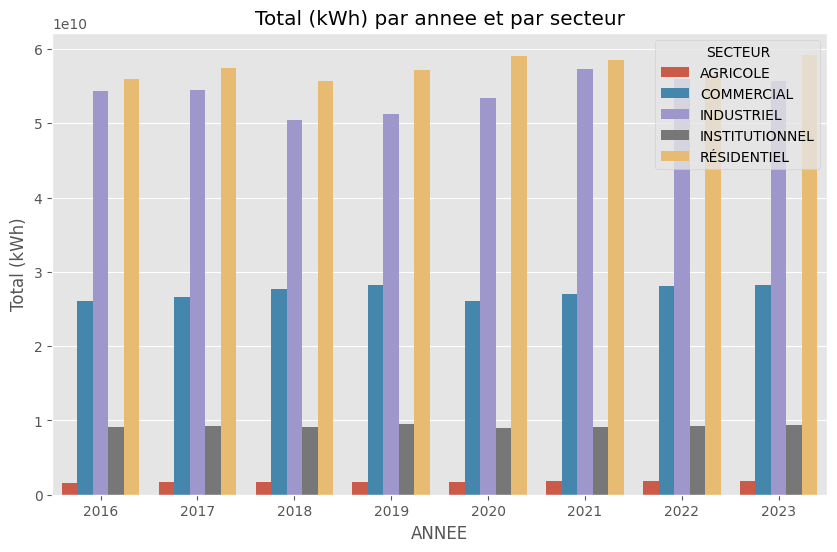

In [19]:
# Create the grouped bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='ANNEE', y='Total (kWh)', hue='SECTEUR', data=df_secteur2_0)
#plt.xticks(ticks=[0, 1], labels=['Non-Recession', 'Recession'])
plt.xlabel('ANNEE')
plt.ylabel('Total (kWh)')
plt.title('Total (kWh) par annee et par secteur')

plt.show()

### B- SECTEUR RESIDENTIEL VS Consommation

In [20]:
df_residentiel_annee = df_conso[df_conso['SECTEUR']=='RÉSIDENTIEL'].groupby(['ANNEE'])['Total (kWh)'].sum()
df_residentiel_annee_mois = df_conso[df_conso['SECTEUR']=='RÉSIDENTIEL'].groupby(['ANNEE_MOIS'], as_index=True )['Total (kWh)'].sum()

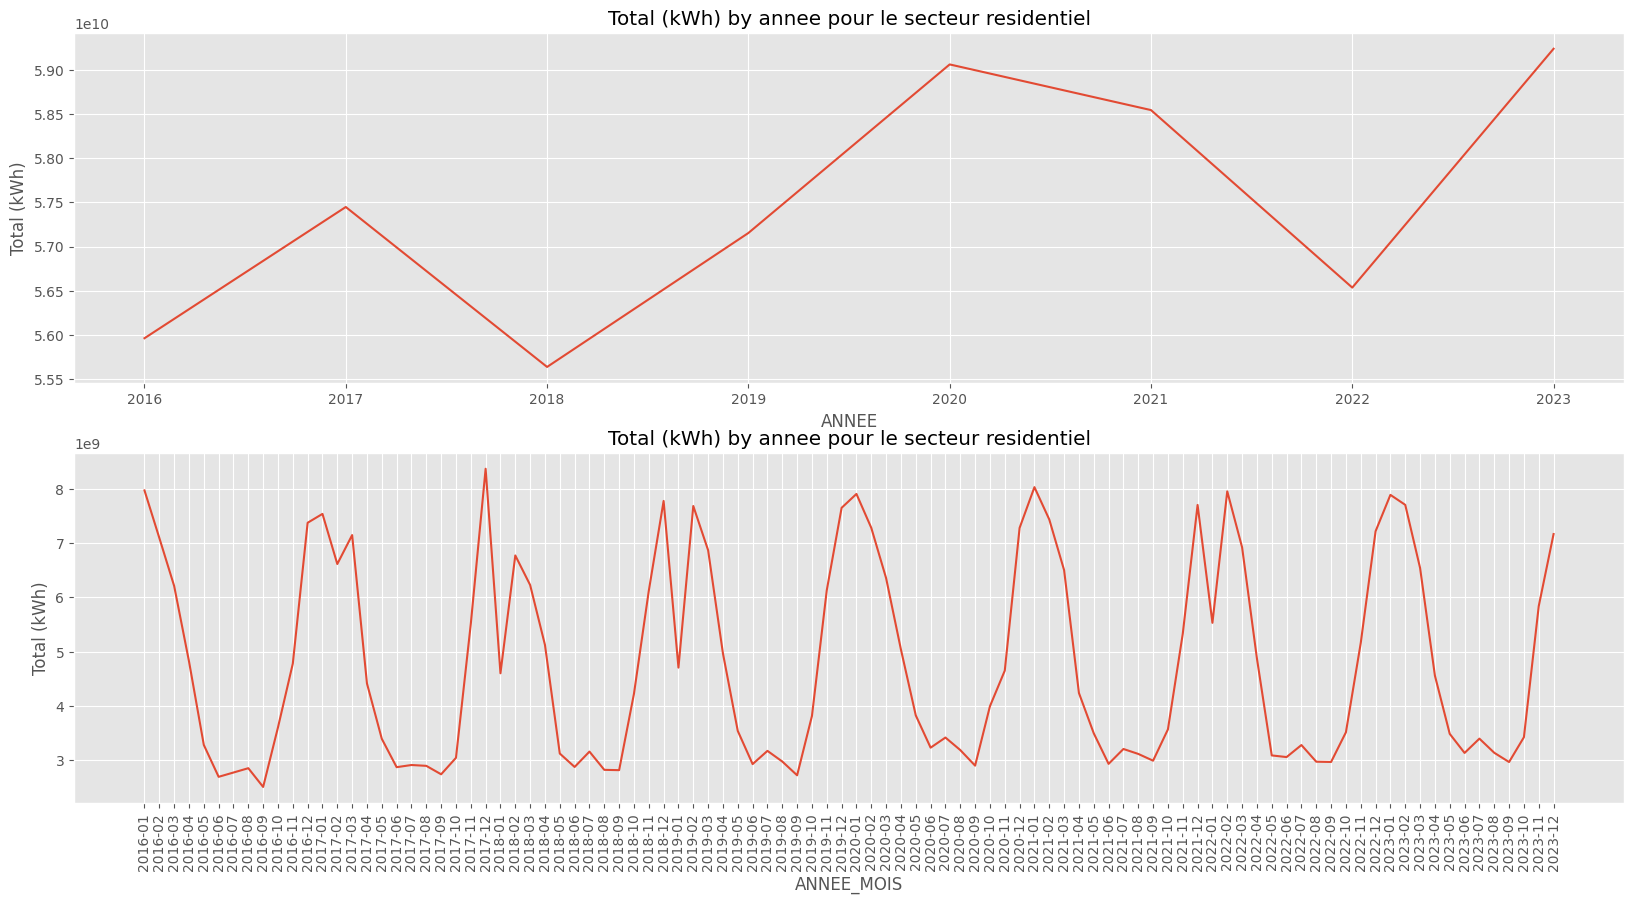

In [21]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 1, 1) # add subplot 1 (2 row, 1 columns, first plot)
ax1 = fig.add_subplot(2, 1, 2) # add subplot 2 (2 row, 1 columns, second plot). 

# Subplot 1: Consommation résidentielle par année
df_residentiel_annee.plot(kind = 'line', figsize=(20, 10), ax=ax0) # add to subplot 1)
ax0.set_xlabel('ANNEE')
ax0.set_ylabel('Total (kWh)')
ax0.set_title('Total (kWh) by annee pour le secteur residentiel')


# Subplot 2: Consommation résidentielle par année-mois
df_residentiel_annee_mois.plot(kind = 'line', figsize=(20, 10), ax=ax1) # add to subplot 2
ax1.set_xticks(range(len(df_conso['ANNEE_MOIS'].unique())),df_residentiel_annee_mois.index,rotation = 90)
ax1.set_xlabel('ANNEE_MOIS')
ax1.set_ylabel('Total (kWh)')
ax1.set_title('Total (kWh) by annee pour le secteur residentiel')


plt.show()

__INTERPRETATION__ : 
> 1- Consommations annuelles élevées en 2018, 2019 et 2022.   
> 2- Par année, la consommation suit une variation saisonnière : très forte en hiver (décembre à mars), décroit durant le printemps et l'été (en particulier de mai à Septembre) puis recommence à croitre pour atteindre un nouveau pic en hiver.

## C- Données Météorologiques VS Consommation 

In [22]:
#Importation des données de météorologique sur la période de 2016 à 2023
df_meteo0 = pd.read_csv('climate-monthly.csv')
df_meteo = pd.DataFrame(df_meteo0)

In [23]:
df_meteo.isnull().sum()

x                               0
y                               0
NORMAL_SUNSHINE              4395
DAYS_WITH_VALID_SUNSHINE     5050
LOCAL_YEAR                      0
DAYS_WITH_VALID_MAX_TEMP        0
LATITUDE                        0
COOLING_DEGREE_DAYS          3525
NORMAL_SNOWFALL              2310
LOCAL_MONTH                     0
DAYS_WITH_VALID_MEAN_TEMP       0
LONGITUDE                       0
ID                              0
DAYS_WITH_VALID_PRECIP          0
MEAN_TEMPERATURE             3525
CLIMATE_IDENTIFIER              0
ENG_PROVINCE_NAME               0
LAST_UPDATED                    0
FRE_PROVINCE_NAME               0
MIN_TEMPERATURE                50
NORMAL_PRECIPITATION          861
TOTAL_SNOWFALL                429
LOCAL_DATE                      0
DAYS_WITH_VALID_MIN_TEMP        0
SNOW_ON_GROUND_LAST_DAY      1121
STATION_NAME                    0
BRIGHT_SUNSHINE              5146
TOTAL_PRECIPITATION           353
HEATING_DEGREE_DAYS          3525
MAX_TEMPERATUR

In [24]:
df_meteo_corr = df_meteo[['LOCAL_YEAR','LOCAL_MONTH',  
       'DAYS_WITH_VALID_MAX_TEMP', 
       'NORMAL_SNOWFALL',  'DAYS_WITH_VALID_MEAN_TEMP',
       'DAYS_WITH_VALID_PRECIP', 'MEAN_TEMPERATURE',
       'MIN_TEMPERATURE', 'NORMAL_PRECIPITATION',
       'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_MIN_TEMP',
       'SNOW_ON_GROUND_LAST_DAY',
       'TOTAL_PRECIPITATION', 'MAX_TEMPERATURE',
       'DAYS_WITH_PRECIP_GE_1MM', 'NORMAL_MEAN_TEMPERATURE',
       'DAYS_WITH_VALID_SNOWFALL']]
#df_meteo_corr = df_meteo_corr.fillna(0)
df_meteo_corr1 = df_meteo_corr.groupby(['LOCAL_YEAR','LOCAL_MONTH']).mean().reset_index()
df_meteo_corr1 = df_meteo_corr1.rename(columns={'LOCAL_YEAR': 'ANNEE', 'LOCAL_MONTH': 'MOIS'})
df_meteo_corr1.head(1)

ANNEE  MOIS  DAYS_WITH_VALID_MAX_TEMP  NORMAL_SNOWFALL  \
0   2016     1                 23.308824        55.130727   

   DAYS_WITH_VALID_MEAN_TEMP  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
0                  19.544118               26.882353         -7.628851   

   MIN_TEMPERATURE  NORMAL_PRECIPITATION  TOTAL_SNOWFALL  \
0       -26.186567             77.256364       30.156061   

   DAYS_WITH_VALID_MIN_TEMP  SNOW_ON_GROUND_LAST_DAY  TOTAL_PRECIPITATION  \
0                 22.014706                17.207547            42.722388   

   MAX_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  NORMAL_MEAN_TEMPERATURE  \
0         6.829412                 9.686567               -11.465273   

   DAYS_WITH_VALID_SNOWFALL  
0                 27.014706

In [25]:
df_conso_annee_mois = df_conso.groupby(['ANNEE', 'MOIS'])['Total (kWh)'].sum().reset_index()
merged_df = pd.merge(df_conso_annee_mois, df_meteo_corr1, on=['ANNEE', 'MOIS'], how='inner')
merged_df1 = merged_df.drop(columns=['ANNEE', 'MOIS'])
merged_df1.head(1)

Total (kWh)  DAYS_WITH_VALID_MAX_TEMP  NORMAL_SNOWFALL  \
0  16583784645                 23.308824        55.130727   

   DAYS_WITH_VALID_MEAN_TEMP  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
0                  19.544118               26.882353         -7.628851   

   MIN_TEMPERATURE  NORMAL_PRECIPITATION  TOTAL_SNOWFALL  \
0       -26.186567             77.256364       30.156061   

   DAYS_WITH_VALID_MIN_TEMP  SNOW_ON_GROUND_LAST_DAY  TOTAL_PRECIPITATION  \
0                 22.014706                17.207547            42.722388   

   MAX_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  NORMAL_MEAN_TEMPERATURE  \
0         6.829412                 9.686567               -11.465273   

   DAYS_WITH_VALID_SNOWFALL  
0                 27.014706

In [26]:
#Identification des variables les plus corrélées à Total (kWh)
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = merged_df.corr()
corr2 = corr[['Total (kWh)']][(corr > 0.8) | (corr < -0.8)].dropna(axis=0, how='all')
corr2.style.background_gradient(cmap='coolwarm')

__NOTE__ : 
> 1- Exclure NORMAL_SNOWFALL et TOTAL_SNOWFALL parce que l'unité de la variable est non identifiée  
> 2- NORMAL_MEAN_TEMPERATURE et MEAN_TEMPERATURE sont corrélés à 98%. On retient uniquement MEAN_TEMPERATURE 

__INTERPRETATION__ : 
> 1- Une baisse de la température entraine une augmentation de la consommation Total (kWh)   
> 2- Une augmentation de la température entraine une baisse de la consommation Total (kWh)

In [27]:
df_conso_vs_meteo = merged_df[['ANNEE','MOIS','Total (kWh)', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','MAX_TEMPERATURE']]
df_conso_vs_meteo['ANNEE_MOIS'] = df_conso_vs_meteo['ANNEE'].astype(str) + '-' + df_conso_vs_meteo['MOIS'].astype(str)
df_conso_vs_meteo['ANNEE_MOIS'] = pd.to_datetime(df_conso_vs_meteo['ANNEE_MOIS'])
df_conso_vs_meteo['ANNEE_MOIS'] = df_conso_vs_meteo['ANNEE_MOIS'].dt.date.apply(lambda x: x.strftime('%Y-%m'))

df_meteo_plot = df_conso_vs_meteo.drop(columns=['ANNEE', 'MOIS','Total (kWh)','MEAN_TEMPERATURE'])
#df_meteo_plot = df_meteo_plot.groupby(['ANNEE_MOIS']).mean().sort_values(by=['ANNEE_MOIS'])
df_meteo_plot = df_meteo_plot.groupby(['ANNEE_MOIS'], as_index=True).mean()

df_meteo_plot_annee = df_conso_vs_meteo.drop(columns=['ANNEE_MOIS', 'MOIS','Total (kWh)','MEAN_TEMPERATURE'])
#df_meteo_plot = df_meteo_plot.groupby(['ANNEE_MOIS']).mean().sort_values(by=['ANNEE_MOIS'])
df_meteo_plot_annee = df_meteo_plot_annee.groupby(['ANNEE'], as_index=True).mean()

C:\Users\Natasha\AppData\Local\Temp\ipykernel_2016\3217522310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conso_vs_meteo['ANNEE_MOIS'] = df_conso_vs_meteo['ANNEE'].astype(str) + '-' + df_conso_vs_meteo['MOIS'].astype(str)
C:\Users\Natasha\AppData\Local\Temp\ipykernel_2016\3217522310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conso_vs_meteo['ANNEE_MOIS'] = pd.to_datetime(df_conso_vs_meteo['ANNEE_MOIS'])
C:\Users\Natasha\AppData\Local\Temp\ipykernel_2016\3217522310.py:4: SettingWithCopy

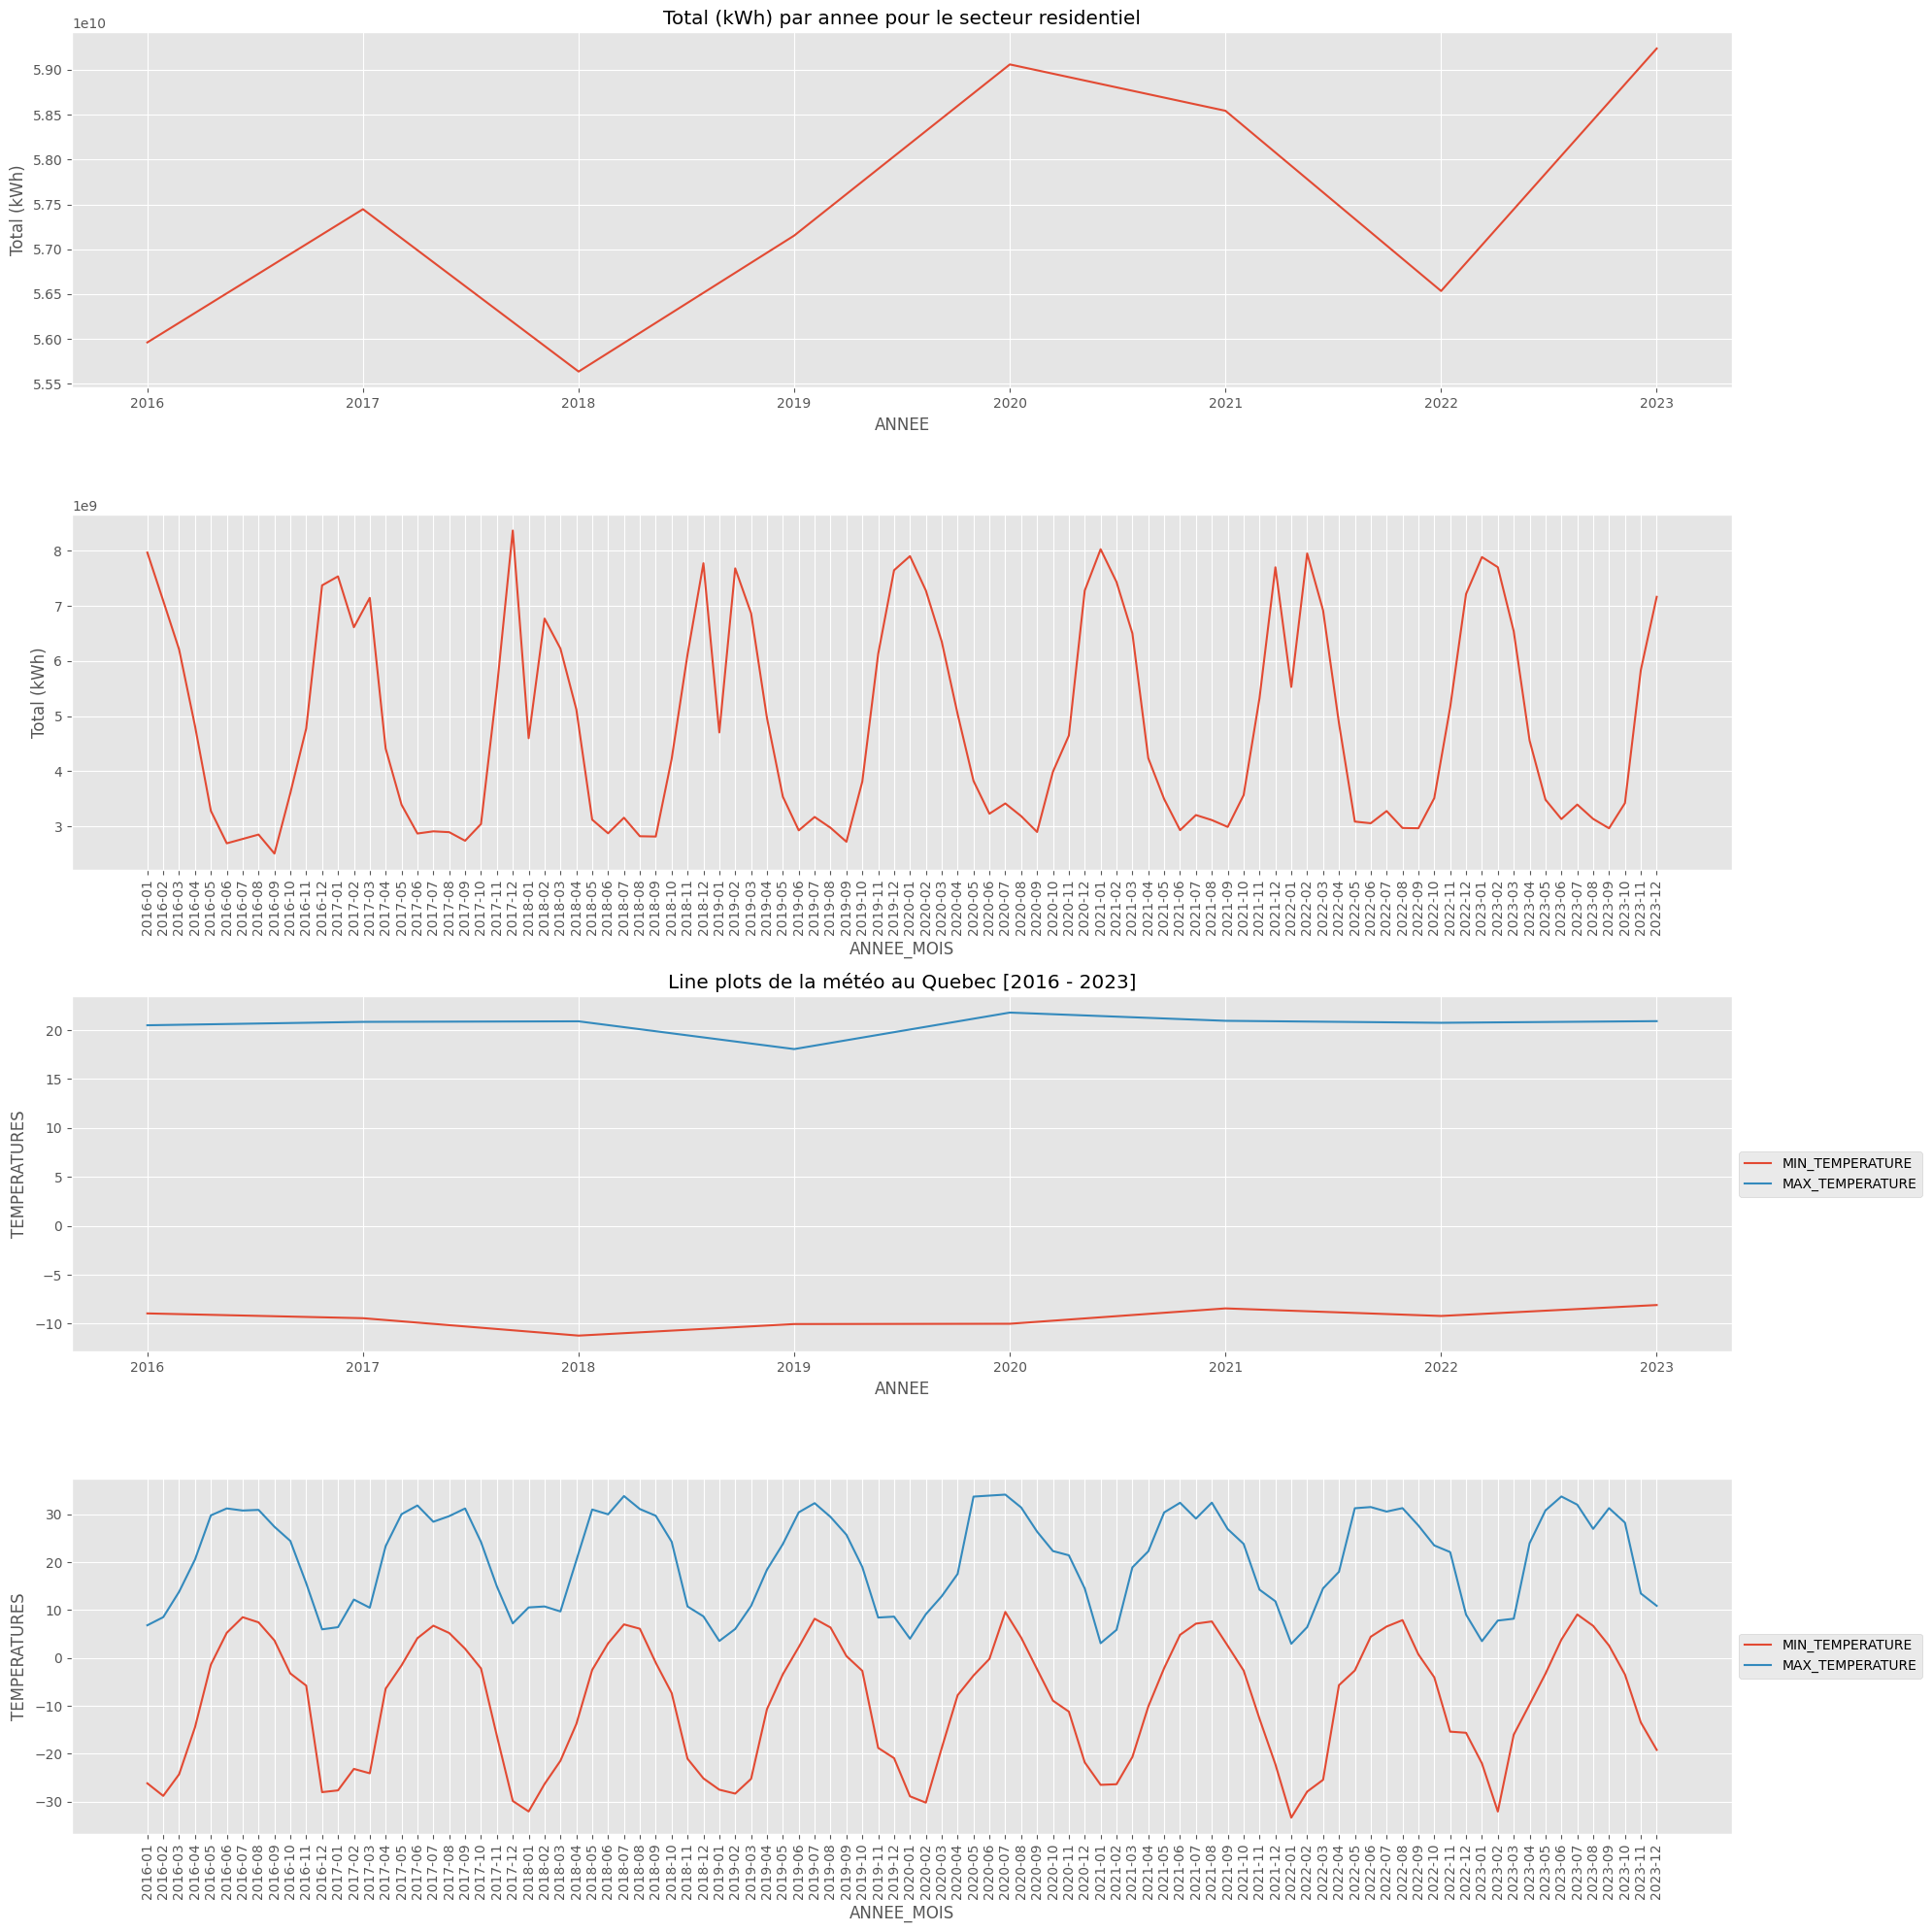

In [28]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(4, 1, 1) # add subplot 1 (4 row, 1 columns, first plot)
ax1 = fig.add_subplot(4, 1, 2) # add subplot 2 (4 row, 1 columns, second plot). 
ax2 = fig.add_subplot(4, 1, 3) # add subplot 2 (4 row, 1 columns, third plot). 
ax3 = fig.add_subplot(4, 1, 4) # add subplot 2 (4 row, 1 columns, fourth plot). 

# Subplot 1: Consommation résidentielle par année
df_residentiel_annee.plot(kind = 'line', figsize=(20, 20), ax=ax0) # add to subplot 1)
ax0.set_xlabel('ANNEE')
ax0.set_ylabel('Total (kWh)')
ax0.set_title('Total (kWh) par annee pour le secteur residentiel')

# Subplot 2: Consommation résidentielle par année-mois
df_residentiel_annee_mois.plot(kind = 'line', figsize=(20, 20), ax=ax1) # add to subplot 2
ax1.set_xticks(range(len(df_conso['ANNEE_MOIS'].unique())),df_residentiel_annee_mois.index,rotation = 90)
ax1.set_xlabel('ANNEE_MOIS')
ax1.set_ylabel('Total (kWh)')


df_meteo_plot_annee.plot(kind='line', figsize=(20, 20), ax=ax2) 
ax2.set_title ('Line plots de la météo au Quebec [2016 - 2023]')
ax2.set_ylabel('TEMPERATURES')
ax2.set_xlabel('ANNEE')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


df_meteo_plot.plot(kind='line', figsize=(20, 20), ax=ax3) # add to subplot 2
ax3.set_xticks(range(len(df_conso_vs_meteo['ANNEE_MOIS'].unique())),df_meteo_plot.index,rotation = 90)
ax3.set_ylabel('TEMPERATURES')
ax3.set_xlabel('ANNEE_MOIS')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.show()

In [29]:
df_meteo_plot_annee

MIN_TEMPERATURE  MAX_TEMPERATURE
ANNEE                                  
2016         -8.944667        20.495537
2017         -9.433261        20.842295
2018        -11.213103        20.898755
2019        -10.031769        18.062290
2020        -10.001565        21.792246
2021         -8.432045        20.950611
2022         -9.205745        20.748665
2023         -8.088694        20.915979

__INTERPRETATION__ :  Les années 2018, 2019 et 2022 qui présentaient des pics élevés de forte consommation sont marquées par des températures minimales moyennes les plus basses soient respectivement -12,54° , -12,14° et -12,19°

### D- Régions VS Consommation

In [30]:
#Importation des données de géolocalisation des régions administratives
donnees_geospatiales = gpd.read_file('regio_s.shp')
donnees_geospatiales = donnees_geospatiales.rename(columns={'RES_NM_REG': 'REGION_ADM_QC_TXT', 'geometry':'Polygon'})
donnees_geospatiales = donnees_geospatiales[['REGION_ADM_QC_TXT','Polygon']]
donnees_geospatiales.head()

REGION_ADM_QC_TXT                                            Polygon
0           Côte-Nord  POLYGON ((-58.10112 52.56837, -58.10031 52.569...
1  Capitale-Nationale  POLYGON ((-69.80551 48.14326, -69.80176 48.143...
2            Mauricie  POLYGON ((-74.62853 48.96793, -74.62843 48.967...
3           Côte-Nord  MULTIPOLYGON (((-68.62427 55.00012, -68.49926 ...
4      Nord-du-Québec  POLYGON ((-77.50000 62.57945, -77.49859 62.579...

In [31]:
df_region = df_conso.groupby(['REGION_ADM_QC_TXT'])['Total (kWh)'].sum().reset_index()
df_region_geom = pd.merge(df_region, donnees_geospatiales, on=['REGION_ADM_QC_TXT'], how='inner').reset_index()
df_region_geom['index'] = df_region_geom['index'].astype(str)

In [32]:
#Conversion de la colonne Polygon en type géométrique
df_region_geom['Polygon'] = df_region_geom['Polygon'].astype(str).apply(shapely.wkt.loads)
df_region_geom = gpd.GeoDataFrame(df_region_geom, geometry='Polygon', crs='EPSG:4326')

In [41]:
# Créer la carte
map = folium.Map(location=[53.000000, -70.000000], zoom_start=4)
# Colorer la zone suivant la demande
bins1 = list(df_region_geom["Total (kWh)"].quantile([0, 0.25, 0.5, 0.75, 1]))

if bins1 == [0, 0, 0, 0, 0] : 
  pass
else :
  choropleth1 = folium.Choropleth(
      geo_data = df_region_geom,
      name = 'Total (kWh)',
      data = df_region_geom,
      columns = ['index', 'Total (kWh)'],
      key_on = 'feature.id',
      fill_color ='YlOrRd',
      fill_opacity = 0.7,
      line_opacity = 0.2,
      legend_name = 'Total (kWh)',
      bins = bins1,
      reset = True
      ).add_to(map)

  #Ajouter le nom des zones de demandes
  choropleth1.geojson.add_child(folium.features.GeoJsonTooltip(['REGION_ADM_QC_TXT'] , labels = False))

#Ajouter une gestionnaire
folium.LayerControl().add_to(map)

#Afficher la carte
map

In [34]:
df_region.sort_values(by=['Total (kWh)'] , ascending=False)

REGION_ADM_QC_TXT   Total (kWh)
12                        Montréal  229504434423
13                      Montérégie  213056206390
2               Capitale-Nationale  136125818113
5                        Côte-Nord  129457830517
3                 Centre-du-Québec   86055418687
9                      Laurentides   76098199939
4             Chaudière-Appalaches   59309467549
8                       Lanaudière   57077325851
16        Saguenay--Lac-Saint-Jean   55662714808
11                        Mauricie   46006319148
0            Abitibi-Témiscamingue   45065162940
10                           Laval   43432033212
7   Gaspésie--Îles-de-la-Madeleine   12689950118
14                  Nord-du-Québec    7306312487
15                       Outaouais    1467024981
1                Bas-Saint-Laurent             0
6                           Estrie             0

__INTERPRETATION__ : Tout secteur confondu, sur la période de 2016 à 2023, les régions ayant le plus consommé d'énergie sont Montréal, Montérégie, Capitale-Nationale et Côte-Nord avec des consommations dépassant les 100 milliard de kWh

In [35]:
df_region_annee = df_conso.groupby(['REGION_ADM_QC_TXT', 'ANNEE'])['Total (kWh)'].sum().reset_index()
df_region_annee2 = pd.crosstab(df_region_annee['REGION_ADM_QC_TXT'], df_region_annee['ANNEE'], values=df_region_annee['Total (kWh)'], aggfunc='sum').reset_index()
df_region_geom_annee = pd.merge(df_region_annee2, donnees_geospatiales, on=['REGION_ADM_QC_TXT'], how='inner').reset_index()
df_region_geom_annee['index'] = df_region_geom_annee['index'].astype(str)
new_columns = ['index', 'REGION_ADM_QC_TXT','2016','2017', '2018', '2019','2020', '2021',  '2022','2023','Polygon']

# Rename all columns
df_region_geom_annee.columns = new_columns

In [37]:
#Conversion de la colonne Polygon en type géométrique
df_region_geom_annee['Polygon'] = df_region_geom_annee['Polygon'].astype(str).apply(shapely.wkt.loads)
df_region_geom_annee = gpd.GeoDataFrame(df_region_geom_annee, geometry='Polygon', crs='EPSG:4326')
# Créer la carte
map2 = folium.Map(location=[53.000000, -70.000000], zoom_start=4)
    
# Create multiple choropleth layers for each year
choropleth_layers = []
for year in range(2016, 2023):
    bins2 = list(df_region_geom_annee[f'{year}'].quantile([0, 0.25, 0.5, 0.75, 1]))
    if bins2 == [0, 0, 0, 0, 0] : 
        pass
    else :
    
        choropleth_layer = folium.Choropleth(
            geo_data=df_region_geom_annee,
            data=df_region_geom_annee,
            name = f'{year}',
            columns=['index', f'{year}'],
            key_on='feature.id',
            fill_color='YlOrRd',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name=f'{year}',
            highlight=True,
            bins = bins2,
            reset = True
    ).add_to(map2)

# Colorer la zone suivant la demande
bins2 = list(df_region_geom_annee['2023'].quantile([0, 0.25, 0.5, 0.75, 1]))

if bins2 == [0, 0, 0, 0, 0] : 
  pass
else :
  choropleth2 = folium.Choropleth(
      geo_data = df_region_geom_annee,
      name = '2023',
      data = df_region_geom_annee,
      columns = ['index', '2023'],
      key_on = 'feature.id',
      fill_color ='YlOrRd',
      fill_opacity = 0.7,
      line_opacity = 0.2,
      legend_name = '2023',
      bins = bins2,
      reset = True
      ).add_to(map2)
#Ajouter le nom des zones de demandes
choropleth2.geojson.add_child(folium.features.GeoJsonTooltip(['REGION_ADM_QC_TXT'] , labels = False))          
#Ajouter une gestionnaire
folium.LayerControl().add_to(map2)

#Afficher la carte
#map2

__NOTE__ : Une carte dynamique à l'aide du module TimeSliderChoropleth de Folium aurait sans doute été plus pertinente pour représenter les consommations de chaque région administrative par année

In [38]:
#Sauvegarde sous format htlm
Heat_map = map.save('Heat_map_global.html')
#Sauvegarde sous format htlm
Heat_map2 = map2.save('Heat_map_par_annee.html')

### E- Régions et Secteurs VS Consommation

In [39]:
df_region_secteur = pd.crosstab(df_conso['REGION_ADM_QC_TXT'], df_conso['SECTEUR'], values=df_conso['Total (kWh)'], aggfunc='sum')
df_region_secteur=df_region_secteur.sort_values(by=['RÉSIDENTIEL'], ascending=False)
df_region_secteur=df_region_secteur[['RÉSIDENTIEL','INDUSTRIEL','COMMERCIAL', 'INSTITUTIONNEL','AGRICOLE']]
df_region_secteur


SECTEUR                         RÉSIDENTIEL    INDUSTRIEL   COMMERCIAL  \
REGION_ADM_QC_TXT                                                        
Montréal                        95079313317   31061648161  81675591817   
Montérégie                      93227975076   71001300369  33335882583   
Capitale-Nationale              51692363317   51035375610  25801311124   
Laurentides                     50013561465    5907660983  15598291408   
Lanaudière                      35736845101    6137743027   8946464708   
Chaudière-Appalaches            28099937095   15368857728  10123912585   
Laval                           27293898511    3182288969  10788211790   
Mauricie                        19397511720   16970507468   6911368686   
Saguenay--Lac-Saint-Jean        17030998862   23612955297   6149197285   
Centre-du-Québec                16371600455   58685487639   6804370968   
Abitibi-Témiscamingue           10315560799   28142959494   4165657974   
Gaspésie--Îles-de-la-Madeleine   6753573527    2114059588   2693662582   
Côte-Nord                        6429528939  115942782273   3684367000   
Nord-du-Québec                   1596969442    3218590525   1053436118   
Outaouais                         535294010     600748669    229008797   
Bas-Saint-Laurent                         0             0            0   
Estrie                                    0             0            0   

SECTEUR                         INSTITUTIONNEL    AGRICOLE  
REGION_ADM_QC_TXT                                           
Montréal                           21599135452    88745676  
Montérégie                         11373144178  4117904184  
Capitale-Nationale                  6958774516   637993546  
Laurentides                         3711423990   867262093  
Lanaudière                          5171975882  1084297133  
Chaudière-Appalaches                2682231817  3034528324  
Laval                               2084481467    83152475  
Mauricie                            2043216130   683715144  
Saguenay--Lac-Saint-Jean            8143073073   726490291  
Centre-du-Québec                    1876757413  2317202212  
Abitibi-Témiscamingue               2141738583   299246090  
Gaspésie--Îles-de-la-Madeleine      1039036815    89617606  
Côte-Nord                           3368082616    33069689  
Nord-du-Québec                      1431108862     6207540  
Outaouais                             91877368    10096137  
Bas-Saint-Laurent                            0           0  
Estrie                                       0           0

Text(0, 0.5, 'Total (kWh)')

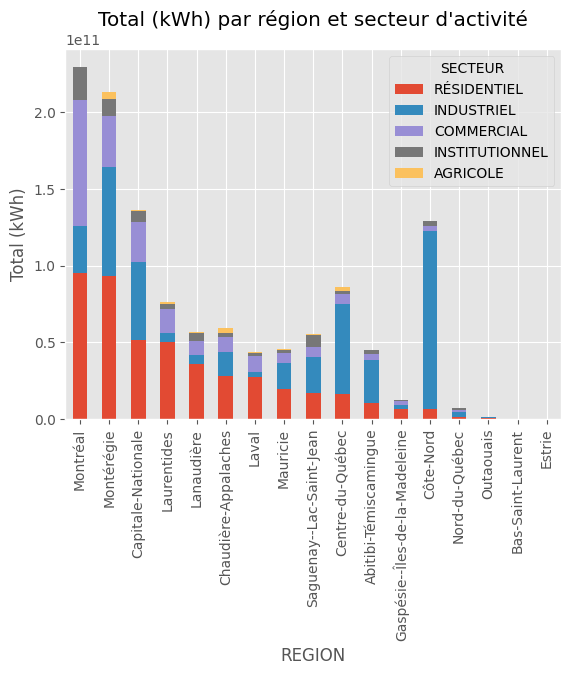

In [40]:
# Barplot
plt = df_region_secteur.plot(kind="bar", stacked=True, rot=90)
plt.set_title("Total (kWh) par région et secteur d'activité")
plt.set_xlabel("REGION")
plt.set_ylabel("Total (kWh)")

__INTERPRETATION__ : Sur la période de 2016 à 2023, les régions administratives consommant le plus d'énergie sont :
> 1- Secteur Résidentiel : Montréal et Montérégie   
> 2- Secteur Industriel : Côte-Nord et Montérégie  
> 3- Secteur Commercial : Montréal et Montérégie  
> 4- Secteur Institutionnel : Montréal et Montérégie   
> 5- Secteur Agricole : Montérégie et Chaudière-Appalaches

## Author

> Natacha Sessou  
> https://www.linkedin.com/in/sara-jelonek-578150162/

## Change Log

|Date (YYYY-MM-DD)|VersionChange| Description|
|-|-|-|
2024-04-29|0.1|Création du notebook|
